<form action="index.ipynb">
    <input type="submit" value="Return to Index" style="background-color: green; color: white; width: 150px; height: 35px; float: right"/>
</form>

# pymcmcstat for Beginners
Author(s): Paul Miles & Ralph Smith | Date Created: July 10, 2019

For those interested in a video, check out our [SciPy 2019](https://www.scipy2019.scipy.org/) presentation on YouTube: [Parameter Estimation Using the Python Package pymcmcstat](https://www.youtube.com/watch?v=rmWlHpGfSio)

What is parameter estimation?  What is Bayesian inference?  No worries if you don't know :)  This tutorial is designed to walk you through the basics of using pymcmcstat.  Throughout this tutorial, we will provide details regarding the statistical language common to Bayesian methods to demystify the process.  At the end of the day, all we are really doing is fitting a model to a set of data!

# Methodology
All models are wrong to a certain extent; however, they may still be useful [[Box76](#box76)].  A useful model can accurately predict the quantity of interest in the presence of uncertainty.  Uncertainty exists in all areas of scientific research and it arises for various reasons. A familiar source of uncertainty in data is simply a certain amount of random noise. Alternatively, uncertainty also occurs due to missing physics in the model or from lack of knowledge. Modeling scientific and engineering problems presents many challenges and often times requires compromise.

To quantify the uncertainty in our modeling problem, we utilize Bayesian inference. The key point in this approach stems from the interpretation of the parameters within the model. A Bayesian approach treats these unknown model parameters as random variables; i.e., they have an underlying probability distribution that can be used to describe them. This contrasts a frequentist approach which assumes the parameters are unknown but have a fixed value. The goal of Bayesian model calibration is to infer the parameter distributions. This approach to inverse problems provides insight into model limitations as well as an accurate estimation of the underlying model and observation uncertainty [[Smi14](#smi14)].

*This next part is super technical, but at the end of the day your main job will be to write a function that calculates the sum-of-squares error.  Hang in there!*

## Bayesian
Estimate posterior densities $\pi(q|F^{obs}(i))$; i.e., probability of parameter values given a set of observations
$$
\pi(q|F^{obs}(i)) = \frac{\mathcal{L}(F^{obs}(i)|q)\pi_0(q)}{\int_{\mathbb{R}^p}\mathcal{L}(F^{obs}(i)|q)\pi_0(q)dq},
$$

- $\mathcal{L}(F^{obs}(i)|q)$ is the likelihood of the observations given a parameter set
- $\pi_0(q)$ is the distribution describing any information known *a priori* about the parameters
- Denominator ensures distribution integrates to 1

Integrating over $\mathbb{R}^p$ makes direct evaluation unrealistic/impossible $\rightarrow$ use **Markov Chain Monte Carlo (MCMC)** methods!

## Markov Chain Monte Carlo (MCMC)
We construct Markov chains whose stationary distribution is the posterior density.  By evaluating realizations of the chain, one thus samples the posterior and hence obtains a density for the parameter values based on observed measurments.  The sampling procedure is performed using some type of Metropolis algorithm.

## Metropolis Algorithm
1. Choose an initial parameter value $q^0$ that satisfies $\pi(q^0|F^{obs}(i))>0$.
2. For $k = 1,...,M$
    - For $z\sim N(0,1)$, construct the candidate: $q^*=q^{k-1} + Rz$.
    - Compute the posterior ratio:  $r(q^*|q^{k-1})=\frac{\pi(q^*|F^{obs}(i))}{\pi(q^{k-1}|F^{obs}(i))} = \frac{\mathcal{L}(F^{obs}(i)|q^*)\pi_0(q^*)}{\mathcal{L}(F^{obs}(i)|q^{k-1})\pi_0(q^{k-1})}.$
    - Set $q^k = \begin{cases}q^*\;\;\;\;,\; \text{with probability } \alpha=\min(1,r), \\q^{k-1}\;,\; \text{else.} \end{cases}$

**Advanced Metropolis Algorithms:**
- MH: Metropolis Hastings
- AM: Adaptive Metropolis [[HST01](#hst01)]
    - Recall: For $z\sim N(0,1)$, construct candidate: $q^*=q^{k-1} + $<font color="red">$R$</font>$z$.
    - Adapt the proposal distribution as information is learned about the posterior distribution from accepted candidates.
- DR: Delayed Rejection [[H+06](#h+06)]
    - Recall: Set $q^k = \begin{cases}q^*\;,\; \text{with probability } \alpha=\min(1,r),\\ \text{Enter DR Algorithm}\end{cases}$
    - Sample from a narrower proposal distribution $\rightarrow$ stimulates mixing within chain
- DRAM: DR + AM

## Statistical Model
The pymcmcstat package is designed to work with statistical models of the form
$$
F^{obs}(i) = F(i; q) + \epsilon_i,\;\; \epsilon_i\sim\mathit{N}(0, \sigma^2).
$$

- $F^{obs}(i)$ - experimental data or high-fidelity simulations
- $F(i; q)$ - model response
- $\epsilon_i$ independent and identically distributed observation errors

$\rightarrow$ The likelihood function becomes $\mathcal{L}(F^{obs}(i)|q) = \exp\Big(-\frac{SS_q}{2\sigma^2}\Big),$
where $SS_q=\sum_{i=1}^{N_{obs}}[F^{obs}(i) - F(i, q)]^2$ is the sum-of-squares error.

## Intuition
For the statistical model we just described, we can gain some intuition on how the Metropolis algorithm works.  Assuming you have a uniform prior distribution; i.e., the probability of any parameter value being true is the same, then the posterior ratio reduces to 
$$r = \frac{\mathcal{L}(F^{obs}(i)|q^*)}{\mathcal{L}(F^{obs}(i)|q^{k-1})} = \exp\Big[-\frac{1}{2\sigma^2}(SS_{q^*}-SS_{q^{k-1}})\Big].$$
This ratio will have a value greater than 1 when $SS_{q^*}<SS_{q^{k-1}}\rightarrow$ Reducing the error means we will accept the candidate $q^*$!  If the candidate leads to an increased error, then it will be accepted with probability $r$.  Because of this, an increase in error will occassionally be accepted, which helps the algorithm escape from local minima and fully explore the parameter space.

# Example Problem
- We have a set of data that follows a quadratic trend - $F^{obs}(i)=2x^2 + 1x - 5$.
- Define observation errors with variance $\sigma^2=0.04 \rightarrow \sigma=0.2$.
- Calibrate a model of the form $F(i; q) = y(x; q)=ax^2 + bx + c$, where $q=[a, b, c]$.

## Observations - $F^{obs}(i)$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pymcmcstat.MCMC import DataStructure

# Define model function
def model(q, data):
    a, b, c = q  # slope and offset
    x = data.xdata[0]
    return a*x**2 + b*x + c

data = DataStructure()
data.add_data_set(x=np.linspace(0, 1, num=100), y=None)
qtrue = [2.0, 1.0, -5.0]
x = data.xdata[0]
sigma = 0.1  # observation error variance
# Generate simulated data
y = model(qtrue, data) + sigma*np.random.standard_normal(x.shape)
fig = plt.figure()
ax = fig.gca()
tmp = ax.plot(x, y, '.b')

## Error function $\rightarrow$ Likelihood $\mathcal{L}(F^{obs}(i)|q)$
The main responsibility of the user is to define a sum-of-squares error function that compares the model to the observations.  This will get plugged into the likelihood function $\mathcal{L}(F^{obs}(i)|q)$ inside of pymcmcstat.

In [2]:
# Define sum of squares function
def ssfun(q, data):
    # Extract ydata
    ydata = data.ydata[0]
    # Evaluate model
    ymodel = model(q, data)
    res = ymodel.reshape(ydata.shape) - ydata
    return (res ** 2).sum(axis=0)

## Setup MCMC simulation using pymcmcstat
To setup the simulation, import the MCMC class and initialize an object.  You will then go through the procedure of adding data, defining model settings, and specifying the desired simulation options.

In [3]:
from pymcmcstat.MCMC import MCMC
mcstat = MCMC()
mcstat.data.add_data_set(x, y)  # Add data
mcstat.model_settings.define_model_settings(
    sos_function=ssfun)  # Assign cost function
mcstat.simulation_options.define_simulation_options(
    nsimu=10.0e4,  # No. of MCMC simulations
    updatesigma=True)  # Update variance of obs. errors

This provides sufficient information to run an MCMC simulation, but there are other useful features worth noting for someone starting out with `pymcmcstat`.  For example, the user can add objects to the data structure via the `user_defined_object` keyword argument.  For ideas on how to use this feature, we recommend the tutorials:

- [Beetle](https://nbviewer.jupyter.org/github/prmiles/pymcmcstat/blob/master/tutorials/beetle/Beetle.ipynb)
- [Radiation Source Localization](https://nbviewer.jupyter.org/github/prmiles/pymcmcstat/blob/master/tutorials/radiation_source_localization/radiation_source_localization.ipynb)

Commonly used simulation options include
  
```python
mcstat.simulation_options.define_simulation_options(
    nsimu=10.0e4, # No. of MCMC simulations
    method='dram', # Metropolis algorithm
    updatesigma=True, # Update obs. error var.
    savedir='mcmc_chains', # Output dir.
    save_to_bin=True, # Save chains to binary
    save_to_txt=True, # Save chains to text
    savesize=int(1.0e3), # Saving intervals
    waitbar=False, # Display progress bar
    verbosity=0, # Level of display while running
)
```
Several arguments relate to the ability to save results into a running log file. As the simulation runs, it periodically appends the sampling chain to a file. In this case, it will create binary (`save_to_bin=True`) and text (`save_to_txt=True`) files in a directory (`savedir='mcmc_results'`) and append the latest set of chain values every 1,000 simulations (`savesize=int(1.0e3)`). This can be extremely useful when running simulations over a long period of time. The user can run diagnostics on the latest set of chain results while the simulation is still running. For more details regarding this feature please see the tutorial:

- [Chain Log Files](https://nbviewer.jupyter.org/github/prmiles/pymcmcstat/blob/master/tutorials/saving_to_log_files/Chain_Log_Files.ipynb).

The Metropolis algorithms available in `pymcmcstat` were discussed earlier, and the user can change it via the `method` keyword argument. To update the observation error variance, $\sigma^2$, one sets `updatesigma=True`. The ability to update $\sigma^2$ is a direct result of the form of the likelihood function, and the reader is referred to [[Smi14](#smi14)] for more details.  Note, if the observation error variance is known, then the user can pass it into the simulation as part of the model settings and turn sampling off via
```python
mcstat.model_settings.define_model_settings(
    sos_function=ssfun,  # Assign cost function
    sigma2=0.1)  # Obs. error variance

mcstat.simulation_options.define_simulation_options(
    ...
    updatesigma=False, # Update obs. error var.
    ...
)
```
For more details on estimating the error variance, we recommend several other tutorials:
- [Monod](https://nbviewer.jupyter.org/github/prmiles/pymcmcstat/blob/master/tutorials/monod/Monod.ipynb)
- [Algae](https://nbviewer.jupyter.org/github/prmiles/pymcmcstat/blob/master/tutorials/algae/Algae.ipynb)
- [Estimating Error Variance for Multiple Data Sets](https://nbviewer.jupyter.org/github/prmiles/pymcmcstat/blob/master/tutorials/estimating_error_variance/estimating_error_variance_for_mutliple_data_sets.ipynb)

## Define model parameters $\rightarrow$ Prior distribution $\pi_0(q)$
The user must specify the parameters in the model that need to be calibrated as well as define any limits regarding potential values those parameters can have. By defining parameter minimum and/or maximum limits, the user has specified the prior function $\pi_0(q)$. By default, pymcmcstat assumes a uniform distribution for all parameters; i.e., there is equal probability of the parameter being a particular value between the minimum and maximum limit.  Alternatively, the user can specify a Gaussian prior distribution by using the `prior_mu` and `prior_sigma` keyword arguments.

The following tutorials are useful for learning more about initializing parameters:
- [Using Normal Prior Distributions](https://nbviewer.jupyter.org/github/prmiles/pymcmcstat/blob/master/tutorials/prior_function/prior_function.ipynb)
- [Specifying Sample Variables](https://nbviewer.jupyter.org/github/prmiles/pymcmcstat/blob/master/tutorials/specifying_sample_variables/specifying_sample_variables.ipynb)

In [4]:
# Add model parameters
mcstat.parameters.add_model_parameter(
    name='a',
    theta0=1.5) # initial guess
mcstat.parameters.add_model_parameter(
    name='b',
    theta0=2.75, # initial guess
    minimum=-5, # lower limit
    maximum=5) # upper limit
mcstat.parameters.add_model_parameter(
    name='c',
    theta0=2.75) # initial guess

The MCMC simulation can now be executed!

In [5]:
# Run MCMC simulation
mcstat.run_simulation()


Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
         a:      1.50 [     -inf,       inf] N( 0.00e+00,      inf)
         b:      2.75 [    -5.00,      5.00] N( 0.00e+00,      inf)
         c:      2.75 [     -inf,       inf] N( 0.00e+00,      inf)
 [-----------------100%-----------------] 100000 of 100000 complete in 27.4 sec

## Analyze Results

In [6]:
# Extract results
results = mcstat.simulation_results.results
chain = results['chain']
s2chain = results['s2chain']
names = results['names']
burnin = int(chain.shape[0]/2)
# display chain statistics
mcstat.chainstats(chain[burnin:, :], results)



------------------------------
name      :       mean        std     MC_err        tau     geweke
a         :     2.1614     0.1281     0.0079   162.3664     0.9778
b         :     0.9040     0.1323     0.0080   155.8004     0.9409
c         :    -5.0099     0.0285     0.0014    98.2502     0.9981
------------------------------
Acceptance rate information
---------------
Results dictionary:
Stage 1: 0.73%
Stage 2: 11.27%
Net    : 11.99% -> 11993/100000
---------------
Chain provided:
Net    : 16.21% -> 8105/50000
---------------
Note, the net acceptance rate from the results dictionary
may be different if you only provided a subset of the chain,
e.g., removed the first part for burnin-in.
------------------------------


What do all these numbers mean?!?!?!  I'm glad you asked :)

When displaying the results they broken up into two distinct sections: 1) Statistical measures and diagnostics of the parameter chains and 2) Analysis of the acceptance rate of the Metropolis algorithm.

**1) Statistical measures and diagnostics:**
- `mean`: Mean value of chain passed to `chainstats`.
- `std`: Standard deviation of chain.  Note, these metrics are useful for describing the posteriors if they are in fact Gaussian; however, there is not requirement that your model parameters be Gaussian distributions.  So, a different statistical measure may be a better way of summarizing your chain, or better yet plot it - soon to come!
- `MC_err`: Normalized batch mean standard deviation.
- `tau`: Integrated autocorrelation time.
- `geweke`: Geweke’s convergence diagnostic.

**2) Acceptance rate:**
- `Stage 1` refers to the acceptance rate during the standard Metropolis step.  We clearly see that very few parameter values are actually being accepted.
- `Stage 2` refers to the delayed rejection step, which samples from a narrow proposal distribution as described in the **advanced Metropolis algorithms** section above.
- In general, it is desirable to see a net acceptance rate between 20% and 40%, but there is some flexibility depending on what your are doing.  As a rule of thumb, an acceptance rate ranging from 10% to 50% is *reasonable*. The technical details as to why are discussed in other documents [[HST01](#hst01), [H+06](#h+06), [Smi14](#smi14)].
- Note the appearance of this acceptance rate display will be different depending on what type of Metropolis algorithm you are using; however, it will always provide your net acceptance rate based on the chains provided to `chainstats`.

For those interesting in learning more about advanced chain diagnostics, we recommend the tutorial

- [Running Parallel Chains](https://nbviewer.jupyter.org/github/prmiles/pymcmcstat/blob/master/tutorials/running_parallel_chains/running_parallel_chains.ipynb)

## Plotting diagnostics
### Chain Panel
Now, lets plot the chain to get a better understanding on what the sampling history looks like.

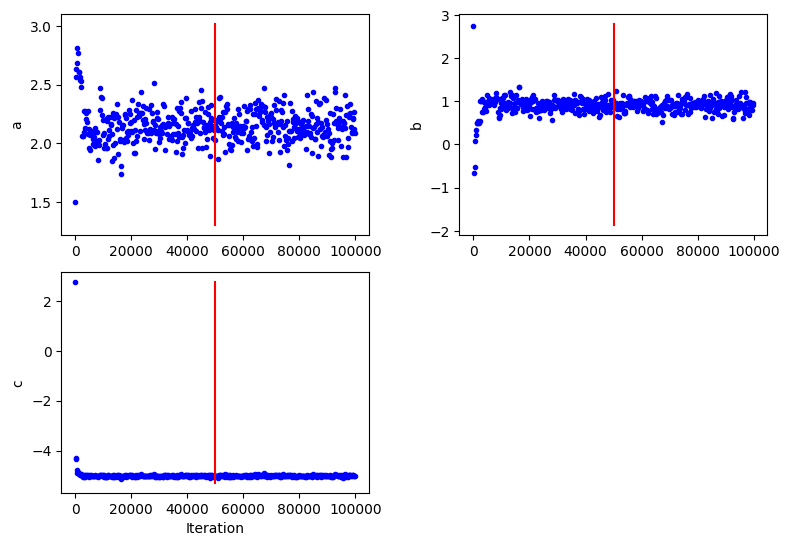

In [7]:
mcpl = mcstat.mcmcplot  # initialize plotting methods
figcp = mcpl.plot_chain_panel(chain, names, figsizeinches=(8, 6))  
axes = figcp.get_axes()
for ii, ax in enumerate(axes):
    ch = chain[:, ii]
    ax.plot([burnin, burnin], [ch.min(), ch.max()], 'r')

As you can see in the plot, each parameter value started at the point where we initialized it when defining `mcstat.parameters`.  The Metropolis algorithm quickly converges to a distribution of values that appears to be center about the expected values ($q_{true}=[2, 1, -5]$ - recall how we  generated the data!) - yippee!  As the Metropolis algorithm takes time to explore the parameter space, we typically remove the first half to allow time for burn-in.  I've plotted a red verticle line half-way through the sampling process.  In practice, we would take all the points to the right of that line as a representative set of points for the posterior distribution.  Removing half of the chain is reasonable based on the visual inspection, where we see a consistent distribution of points with no jumping or stagnation regions (repeated values).  Depending on the appearance of the chain, you can choose other cutoff points for burn-in.

### Density Panel
Now that we have our converged chains, we can use a Kernel Density Estimator (KDE) to plot the PDFs.

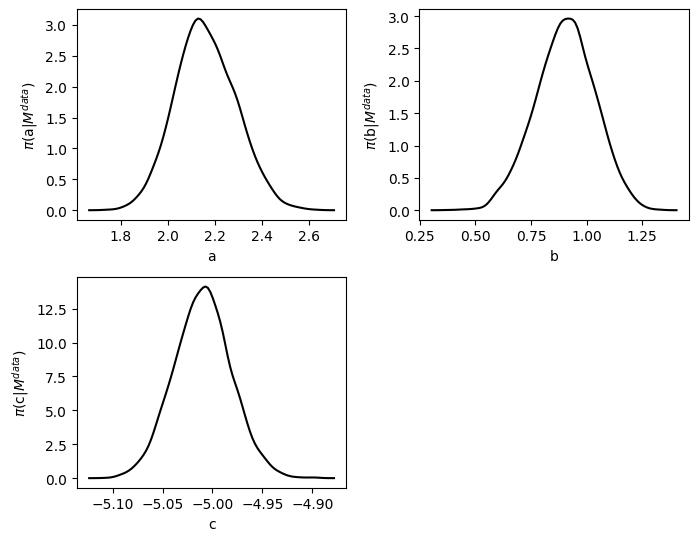

In [8]:
figdp = mcpl.plot_density_panel(chain[burnin::10, :], names, figsizeinches=(7, 6))

These distributions appear to be nominally Gaussian, but that is not a requirement of the algorithm (or the physics).

### Pairwise Correlation Panel
Another plotting routine that is useful to consider is for pairwise correlation.

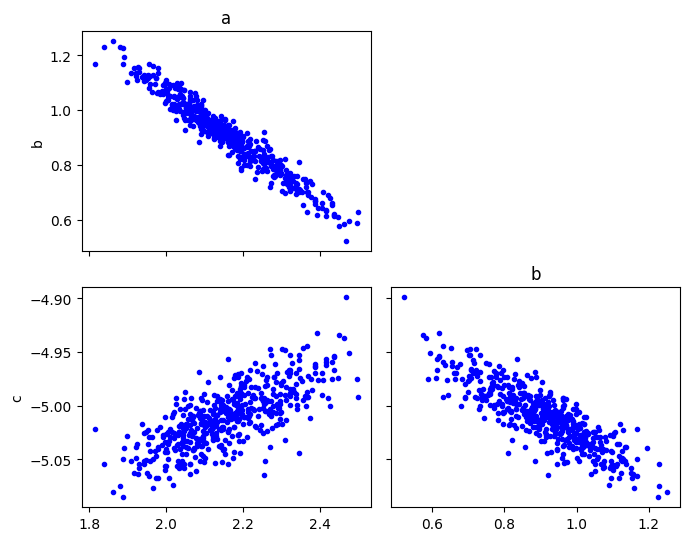

In [9]:
figpc = mcpl.plot_pairwise_correlation_panel(
          chain[burnin:, :], names, figsizeinches=(7, 6))

We are simply plotting the chains against one another, which can often be insightful.  For example, it is possible that a certain combination of parameter values makes your model perform poorly, meaning few or no parameter combinations of that nature will be accepted in the Metropolis algorithm.  This will be clearly apparent when looking at the pairwise correlation.  Also, it may be apparent that one or more of your model parameters have a nearly single-valued relationship, meaning that one can be directly defined by the value of the other and the solution is not unique.  For example, if the plot for [$a, b$] were a completely straight line (or at least very tight), then this implies a potentially nearly single-valued linear correlation.  However, the results presented here are reasonable, and having correlated parameters causes no problems for the MCMC method.

These are the primary chain diagnostics available with `pymcmcstat`, but the user is strongly encouraged to check out other Python visualization packages, such as [seaborn](https://seaborn.pydata.org/).  For ideas on types of plots that you could make, consider looking at [mcmcplot](https://github.com/prmiles/mcmcplot/wiki).  The `chain` generated by `pymcmcstat` is a Numpy array with shape (`nsimu, npar`) where `nsimu` is the number of MCMC simulations and `npar` is the number of parameters being sampled.  With that knowledge, you can use any plotting package you prefer :)

## Uncertainty Propagation
The last plotting feature we wish to point out is with respect to uncertainty propagation.  We will take our posterior distributions as well as knowledge of the observation error variance to generated credible and prediction intervals.

 [-----------------100%-----------------] 500 of 500 complete in 0.0 sec

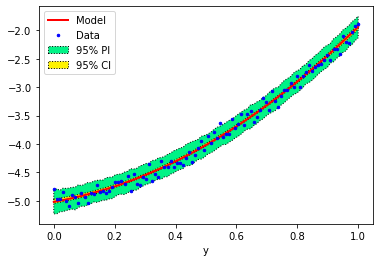

In [10]:
import pymcmcstat.propagation as up
data = mcstat.data
intervals = up.calculate_intervals(
    chain[burnin:, :], results, data, model,
    s2chain=s2chain[burnin:, :], nsample=500, waitbar=True)
fig, ax = up.plot_intervals(
    intervals, data.xdata[0], data.ydata[0], limits=[95],
    adddata=True)
ax.set_xlabel('x')
ax.set_xlabel('y');

The two types of uncertainty intervals shown are credible (CI) and prediction (PI) intervals.  Credible intervals represent the distribution of the model response based soley on propagation of the parameter posterior distributions, which provides a measure of the model fit.  If you sum the propagated uncertainty and observation errors, you get prediction intervals.  As a rule of thumb, one would usually expect to see 95% of your observations within a 95% prediction interval, assuming you are using the correct statistical model.  The results presented above seem reasonable.
  
For more details regarding credible and prediction intervals, please see [[Smi14](#smi14)].  Additional tutorials are available that outline some alternative uncertainty propagation plotting routines:

- [Advanced Interval Plotting](https://nbviewer.jupyter.org/github/prmiles/pymcmcstat/blob/master/tutorials/advanced_interval_plotting/advanced_interval_plotting.ipynb)

We note that the `propagation` module inside of `pymcmcstat` was released as part of version 1.9.0.  Previous versions rely on the `PredictionIntervals` module inside of the `plotting` subpackage.

# Going Forward
This outlines most of the key features of `pymcmcstat`.  Feel free to checkout the other examples located on the [main tutorials page](https://nbviewer.jupyter.org/github/prmiles/pymcmcstat/blob/master/tutorials/index.ipynb?).  Also, if you are interested in a more advanced probablistic programming approach, we highly recommend you consider an alternative package such as [PyMC3](https://docs.pymc.io/).  If nothing else, we hope that this tutorial provided you with some insight on how Metropolis algorithms work and inspired you to consider uncertainty in more aspects of your model development.

# References:
- <a id="box76"></a> [Box76] George E. P. Box. (1976). Science and Statistics. Journal of the American Statistical Association, 71(356):791–799.
- <a id="smi14"></a> [Smi14] Ralph C. Smith. (2014). Uncertainty Quantification: Theory, Implementation, and Applications, SIAM. Volume 12.
- <a id="hst01"></a> [HST01] Haario, H., Saksman, E., & Tamminen, J. (2001). An Adaptive Metropolis Algorithm. Bernoulli, 7(2), 223-242.
- <a id="h+06"></a> [H+06] Haario, H., Laine, M., Mira, A., & Saksman, E. (2006). DRAM: Efficient Adaptive MCMC. Statistics and Computing, 16(4), 339-354.